# Sklearn Interface Tutorial

This tutorial will walk you through using the sklearn style DAGRegressor and DAGClassifier models on two familiar datasets: Boston Housing and Breast Cancer.

**NOTE** `pytorch` is required for this tutorial.

___
## DAGRegressor
This section demonstrates the performance of the DAGRegressor on a real-world dataset. The main things to note in this section are:

- The scale sensitivity of the algorithm

- Interpretability of nonlinear `.coef_`

### The Data: Boston Housing

The boston housing dataset is a classic benchmark regression task. The objective is to predict a set of house prices given a small set of features.

The meaning of the set of available features is shown below.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
data = load_boston()
print(data["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Lets initially benchmark the performance of an `ElasticNetCV` fitted across the entire dataset.

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.700


### Linear DAGRegressor

The DAGRegressor has several parameters which can be used to better fit a more complicated noisy DAG:

- `alpha`: The l1 (lasso) regularisation parameter. Increasing this creates a sparser DAG.

- `beta`: The l2 (ridge) regularisation parameter.

It was decided to use `alpha` and `beta` rather than `alpha` and `l1_ratio` like in sklearn elasticnet to uncouple the parameters during optimisation.

There are several parameters which are also of interest which have good defaults, but we highlight here:

- `dependent_target`: This forces the target variable y to be only a child node. This is important for performance because in some cases `X -> y` is indistinguishable from `y -> X`. Enabling this (default enabled) ensures that the regressor performance at least matches linear regression. The trade-off is that the learned structure might be less accurate if y does cause other features.

- `enforce_dag`: This thresholds the learned structure model until the system is a DAG. This is useful for removing the small straggler connections which enables the DAG to be visualised easier. It does not impact performance, because the regressor still uses those connections under the hood.

MEAN R2: 0.706
CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.310018
AGE        0.000000
DIS       -0.224579
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT     -0.372827
dtype: float64


(<Figure size 837.36x526.32 with 1 Axes>, <AxesSubplot:>)

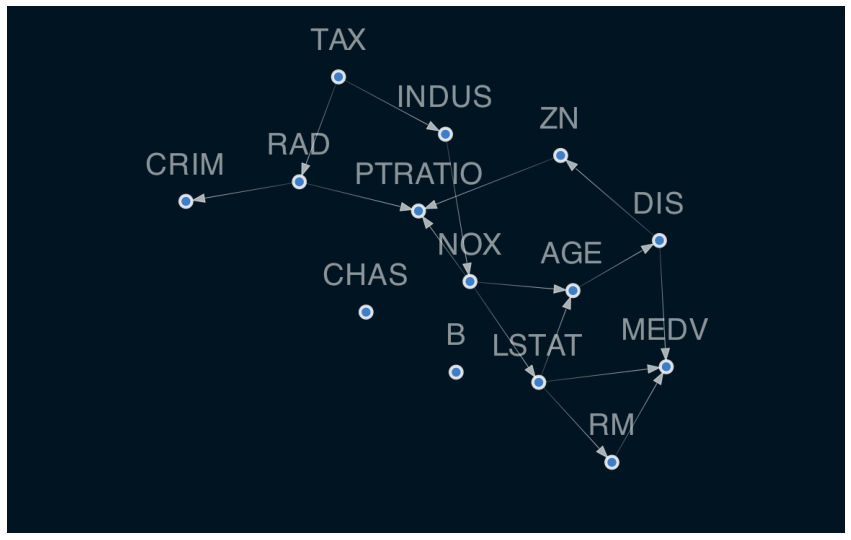

In [4]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=None,
    dependent_target=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

### NonLinear DAGRegressor

Specifying a nonlinear model is extremely simple, only a single parameter needs to be altered: `hidden_layer_units`

`hidden_layer_units` takes _any_ **iterable** of **integers**:

- The value specifies the number of perceptrons to use in each nonlinear MLP layer:

- The number of elements in the iterable determines the number of hidden layers.

The more layers and more perceptrons per layer, the more complicated the function which can be fit. The trade off is a greater tendency to overfit, and slower fitting.

A good default starting argument is ~\[5]. This is unlikely to overfit, and usually demonstrates immediately whether the DAG has nonlinear components.

The setting of the `alpha` and `beta` parameters is very important.
Typically `beta` is more important than `alpha` when using nonlinear layers. This is because l2 is applied across all layers, whereas l1 is only applied to the first layer.
A good starting point is `~beta=0.5`.

**NOTE it is very important to scale your data!**

The nonlinear layers contain sigmoid nonlinearities which can become saturated with unscaled data. Also, unscaled data means that regularisation parameters do not impact weights across features equally.

For convenience, setting `standardize=True` scales both the X and y data during fit. It also inverse transforms the y on predict similar to the sklearn `TransformedTargetRegressor`.

MEAN R2: 0.847


(<Figure size 720.72x576.72 with 1 Axes>, <AxesSubplot:>)

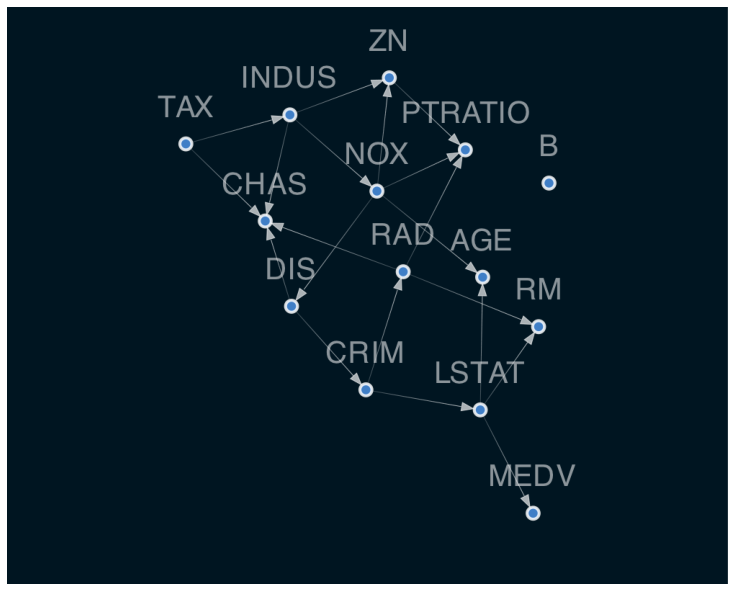

In [5]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

#### Dependent Target

Setting the `dependent_target=False` has an impact on performance as shown below, but can give better insight into the overall nonlinear structure of the data.

This is effectively the same as fitting causalnex on the data using from_pandas, but using the sklearn interface provides a set of useful convenience functions not present in the base causalnex implementation.

MEAN R2: 0.580
MEAN EFFECT DIRECTIONAL:
CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
B          0.0
LSTAT      0.0
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
B          0.0
LSTAT      0.0
dtype: float64


(<Figure size 879.84x447.12 with 1 Axes>, <AxesSubplot:>)

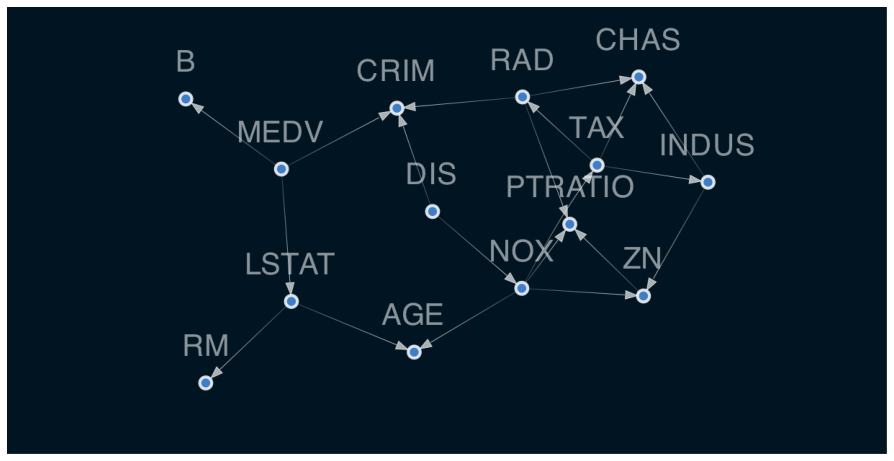

In [6]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    dependent_target=False,
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

#### Interpereting the Nonlinear DAG

For nonlinear analysis, understanding the impact of one feature on another is not as simple as taking the mean effect as in the linear case.
Instead, a combination of `reg.coef_` and `reg.feature_importances` should be used:

- `reg.coef_` provides the mean **directional** effect of all the features on the target. This gives average directional information, but can be misleading in terms of magnitude if the feature has a positive _and_ negative effect on the target.

- `reg.feature_importances_` provides the mean **magnitude** effect of the features on the target. These values will be _strictly larger_ than the `reg.coef_` because there are no cancellation effects due to sign differences. 

The magnitude difference between the `reg.coef_` and `reg.feature_importances_` values can give insight into the _degree of directional variability_ of the parameter:

- A large difference means that the parameter has **large positive and negative effects** on the target.

- A zero difference means that the parameter always has the same directional impact on the target.

MEAN R2: 0.870
MEAN EFFECT DIRECTIONAL:
CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.316868
AGE        0.000000
DIS       -0.282723
RAD        0.151093
TAX       -0.467026
PTRATIO    0.000000
B          0.000000
LSTAT     -0.350534
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.347253
AGE        0.000000
DIS        0.283788
RAD        0.291474
TAX        0.501727
PTRATIO    0.000000
B          0.000000
LSTAT      0.351469
dtype: float64


(<Figure size 613.44x363.6 with 1 Axes>, <AxesSubplot:>)

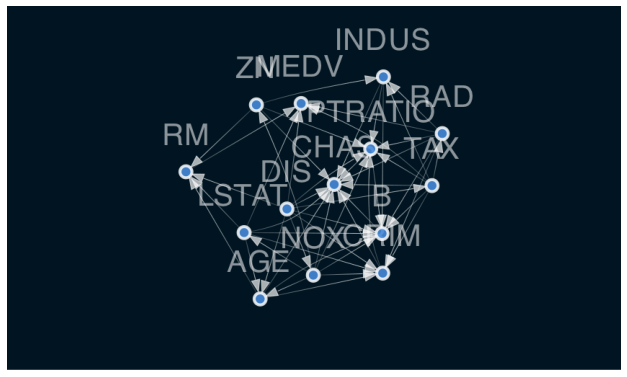

In [8]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.001,
    beta=2,
    hidden_layer_units=[8, 8, 8],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="MEDV")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

The `reg.get_edges_to_node` method allows for analysis of other edges in the graph easily.

Passing in `data="weight"` returns the mean effect magnitude of the variables on the requested node. It is equivalent to the `reg.feature_importances` return for the target node.

Passing in `data="mean_effect"` returns the mean directional effect.

Below is a good example of a large difference between the magnitude and directional effects:

- The feature RAD has overall a large effect on the presence of NOX.

- However, the _directional_ effect of this feature is highly variable, which leads the mean_effect to be an order of magnitude smaller than the mean effect magnitude!

In [9]:
vals = reg.get_edges_to_node("NOX", data="weight").copy()
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.0000
ZN         0.0000
INDUS      0.0000
CHAS       0.0000
NOX        0.0000
RM         0.0000
AGE        0.0000
DIS        0.6565
RAD        0.0000
TAX        0.0000
PTRATIO    0.0000
B          0.0000
LSTAT      0.0000
dtype: float64

In [10]:
vals = reg.get_edges_to_node("NOX", data="mean_effect")
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.0000
ZN         0.0000
INDUS      0.0000
CHAS       0.0000
NOX        0.0000
RM         0.0000
AGE        0.0000
DIS       -0.6565
RAD        0.0000
TAX        0.0000
PTRATIO    0.0000
B          0.0000
LSTAT      0.0000
dtype: float64

___
## DAGClassifier
This section demonstrates the performance of the algorithm on a real-world dataset.

The interface is very similar to the DAGRegressor so key details should be found there.

### Binary Classifier
#### The Data: Breast Cancer

In [11]:
from sklearn.datasets import load_breast_cancer
print(load_breast_cancer(return_X_y=False)["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [12]:

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="NOT CANCER")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))

MEAN Score: 0.944
MEAN EFFECT DIRECTIONAL CLASS 0:
worst radius               1.041636
mean radius                0.979513
mean texture               0.469473
texture error              0.390102
mean perimeter             0.260891
perimeter error            0.156270
radius error               0.042703
smoothness error          -0.003320
fractal dimension error   -0.003441
mean fractal dimension    -0.010169
symmetry error            -0.012280
concave points error      -0.013242
worst area                -0.014235
mean area                 -0.016286
mean smoothness           -0.036755
compactness error         -0.037005
mean symmetry             -0.050893
concavity error           -0.051575
worst fractal dimension   -0.051730
worst smoothness          -0.066606
mean concave points       -0.101790
area error                -0.111632
worst symmetry            -0.161130
mean compactness          -0.172538
worst concave points      -0.195730
worst perimeter           -0.238059
mean concavit

/Users/zain_patel/code/alchemy/.env/causal/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/zain_patel/code/alchemy/.env/causal/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit

MEAN Score: 0.975
MEAN EFFECT DIRECTIONAL CLASS 0:
fractal dimension error    0.437689
texture error              0.253622
mean compactness           0.223662
symmetry error             0.111959
compactness error          0.093871
worst compactness          0.089337
mean fractal dimension     0.036868
concavity error            0.029941
mean texture               0.024005
mean symmetry             -0.000022
mean perimeter            -0.000109
mean area                 -0.000148
mean radius               -0.000768
mean smoothness           -0.007919
perimeter error           -0.020499
concave points error      -0.088629
worst smoothness          -0.173709
smoothness error          -0.173919
worst fractal dimension   -0.196339
worst perimeter           -0.245209
worst concavity           -0.249868
worst symmetry            -0.253354
worst concave points      -0.254314
mean concavity            -0.318881
mean concave points       -0.322732
worst area                -0.429768
worst radius 

(<Figure size 1111.68x753.12 with 1 Axes>, <AxesSubplot:>)

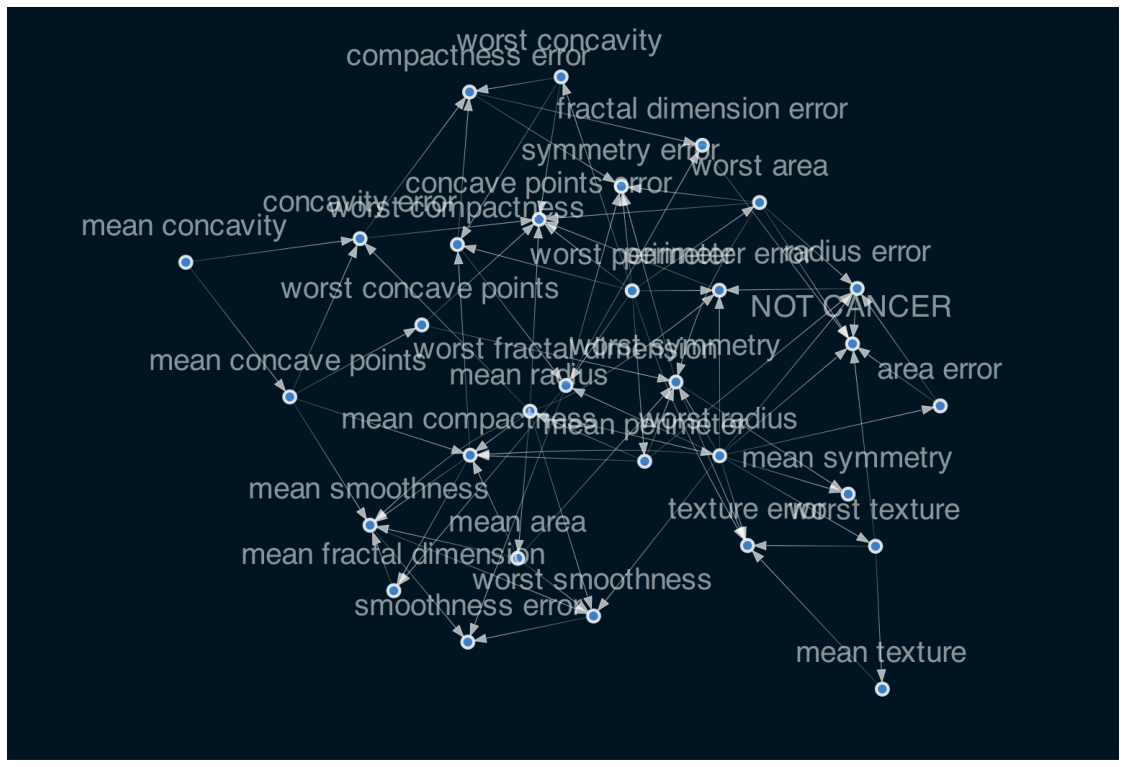

In [13]:

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="NOT CANCER")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)

### Categorical Classifier
#### The Data: Iris

In [14]:
from sklearn.datasets import load_iris
print(load_iris(return_X_y=False)["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

MEAN Score: 0.973
MEAN EFFECT DIRECTIONAL CLASS 0:
sepal width (cm)     0.217801
sepal length (cm)   -0.171877
petal width (cm)    -0.313500
petal length (cm)   -0.357515
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 1:
petal length (cm)    0.256604
petal width (cm)     0.205152
sepal length (cm)    0.154611
sepal width (cm)    -0.154048
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 2:
petal width (cm)     1.798334
petal length (cm)    1.687863
sepal length (cm)   -0.104641
sepal width (cm)    -0.346640
dtype: float64


(<Figure size 549.36x348.48 with 1 Axes>, <AxesSubplot:>)

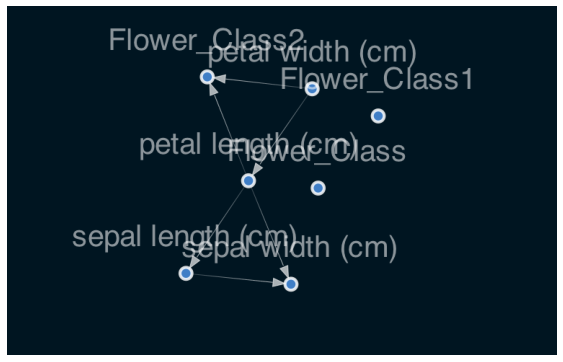

In [15]:

from sklearn.datasets import load_breast_cancer
data = load_iris()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="Flower_Class")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print("MEAN EFFECT DIRECTIONAL CLASS {}:".format(i))
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)